In [18]:
from google.colab import drive
drive.mount("/content/drive/")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import seaborn as sns
import matplotlib.pyplot as plt


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# pokemon_2021 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2021_pokemon_power_level.csv')
# pokemon_2022 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2022_pokemon_power_level.csv')
# pokemon_2023 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2023_pokemon_power_level.csv')
trainer_2021 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2021_trainer_power_level.csv')
trainer_2022 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2022_trainer_power_level.csv')
trainer_2023 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2023_trainer_power_level.csv')



In [3]:
bert_model_filename = "BERT_trainer_fine_tuned_v2"

bert_model = TFBertModel.from_pretrained(f"/content/drive/MyDrive/Data 266/{bert_model_filename}")


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/MyDrive/Data 266/BERT_trainer_fine_tuned_v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [4]:
usecols = ['id', 'name', 'cleaned_abilities', 'cleaned_rules', 'cleaned_attacks', 'hp', 'types', 'subtypes', 'evolvesFrom', 'evolvesTo', 'weaknesses', 'convertedRetreatCost', 'resistances']

train_dat_x = pd.concat([trainer_2021, trainer_2022])[usecols]
train_dat_y = pd.concat([trainer_2021, trainer_2022])['power_level']

test_dat_x = pd.concat([trainer_2023])[usecols]
test_dat_y = pd.concat([trainer_2023])['power_level']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256

tokenized_rules = tokenizer(
    train_dat_x['cleaned_rules'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)
input_ids_rules = tokenized_rules['input_ids']
attention_mask_rules = tokenized_rules['attention_mask']


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
idx = np.argsort(test_dat_y)[::-1]
sorted_test_dat_y = test_dat_y.iloc[idx].iloc[:10]
sorted_test_dat_x = test_dat_x.iloc[idx,:].iloc[:10,:]

X_test_tokenized = tokenizer(
    sorted_test_dat_x['cleaned_rules'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)

bert_outputs = bert_model.bert(
    input_ids=X_test_tokenized['input_ids'],
    attention_mask=X_test_tokenized['attention_mask'],
    token_type_ids=X_test_tokenized['token_type_ids']
)

attentions = bert_outputs.attentions
attentions = np.array([att.numpy() for att in attentions])  # Convert to NumPy array. Shape [12, batch_size, 12, num_tokens, num_tokens]. The 12 is number of layers. The other 12 is number of attention heads.


In [25]:
pairwise_attentions = attentions.mean(axis=(0, 2)) # Shape [batch_size, num_tokens, num_tokens]
print(pairwise_attentions.shape)

(10, 256, 256)


In [30]:
def attention_heatmap(tokens, attention_matrix):
  tokens = np.array(tokens)
  tokens_pad_idx = np.argmax(tokens == '[PAD]')
  if tokens_pad_idx == 0: # no pad
    tokens_pad_idx = len(tokens)
  df = pd.DataFrame(
      attention_matrix[1:tokens_pad_idx-1, 1:tokens_pad_idx-1],
      index=tokens[1:tokens_pad_idx-1],
      columns=tokens[1:tokens_pad_idx-1]
  )
  plt.figure(figsize=(20, 16))
  sns.heatmap(df, annot=False, cmap='Blues')

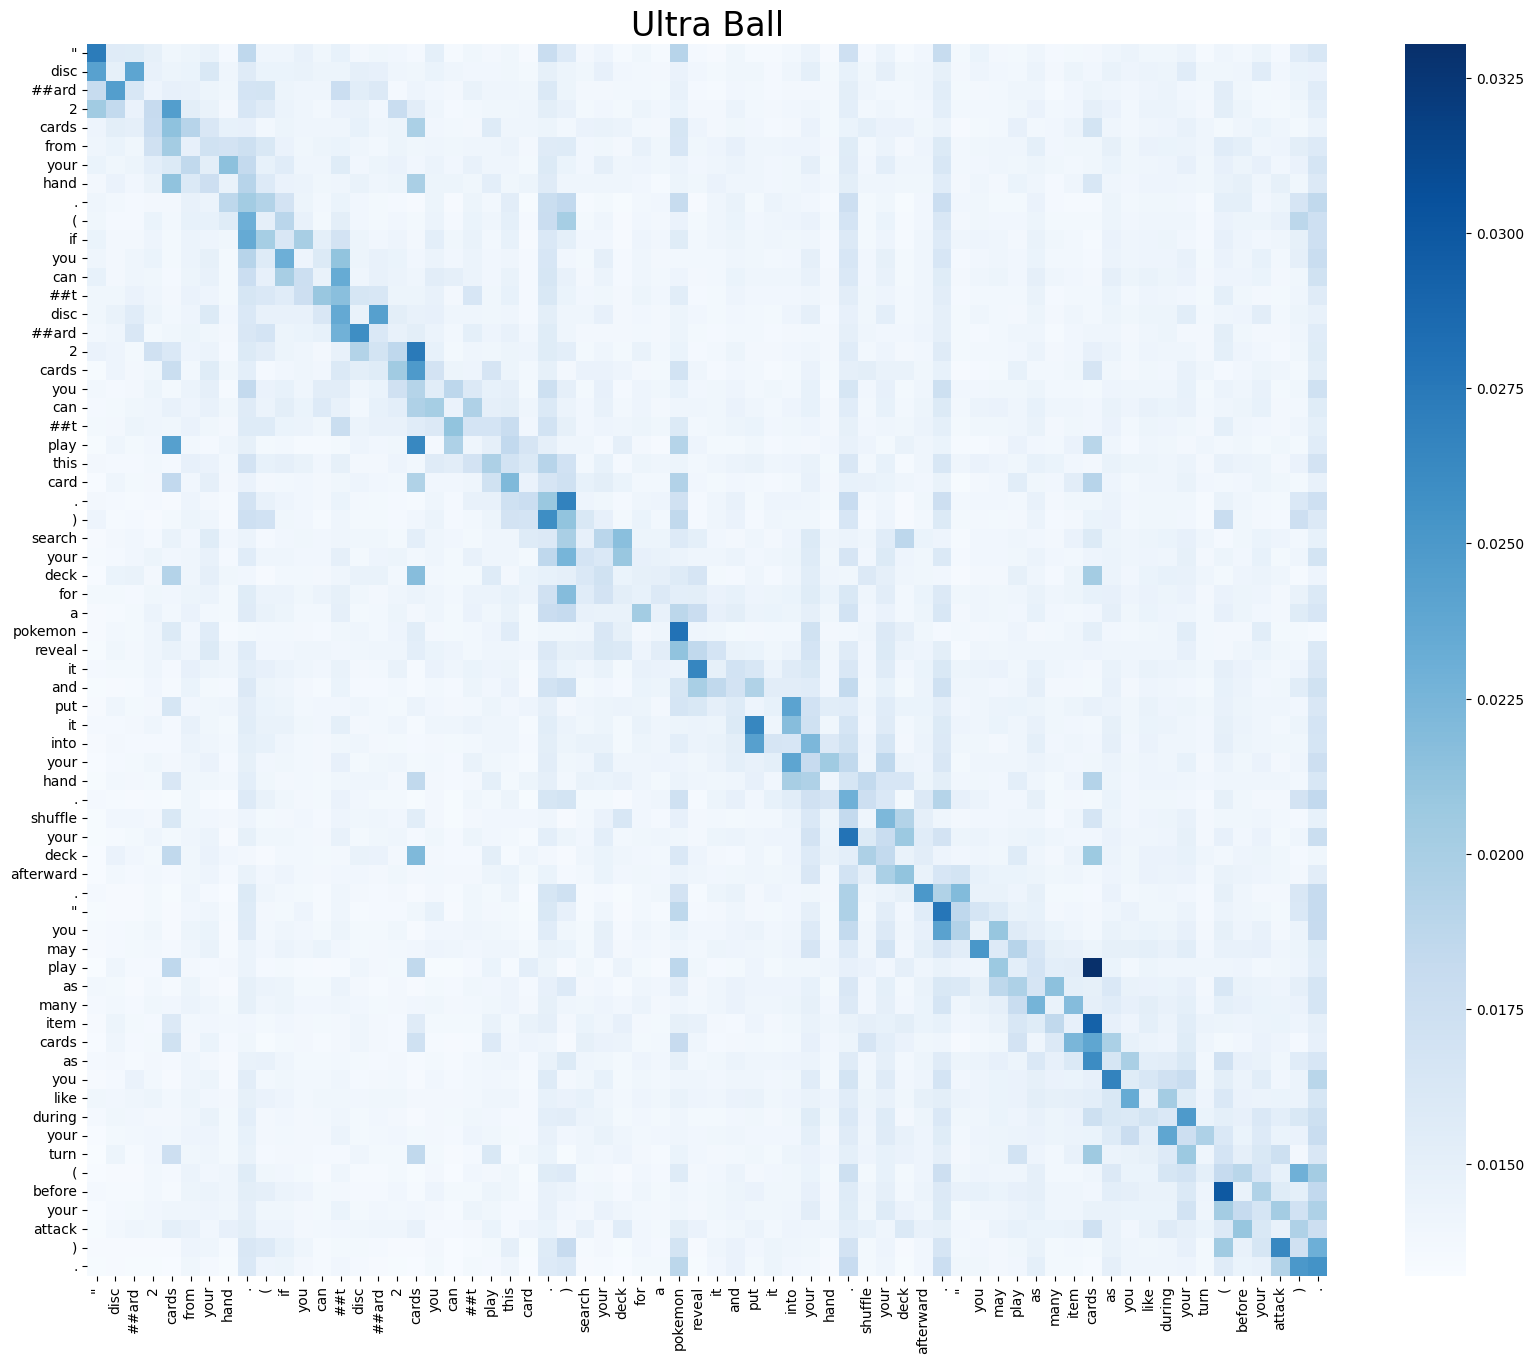

In [34]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[0]),
    pairwise_attentions[0]
)

plt.title(sorted_test_dat_x['name'].iloc[0], fontsize=24);

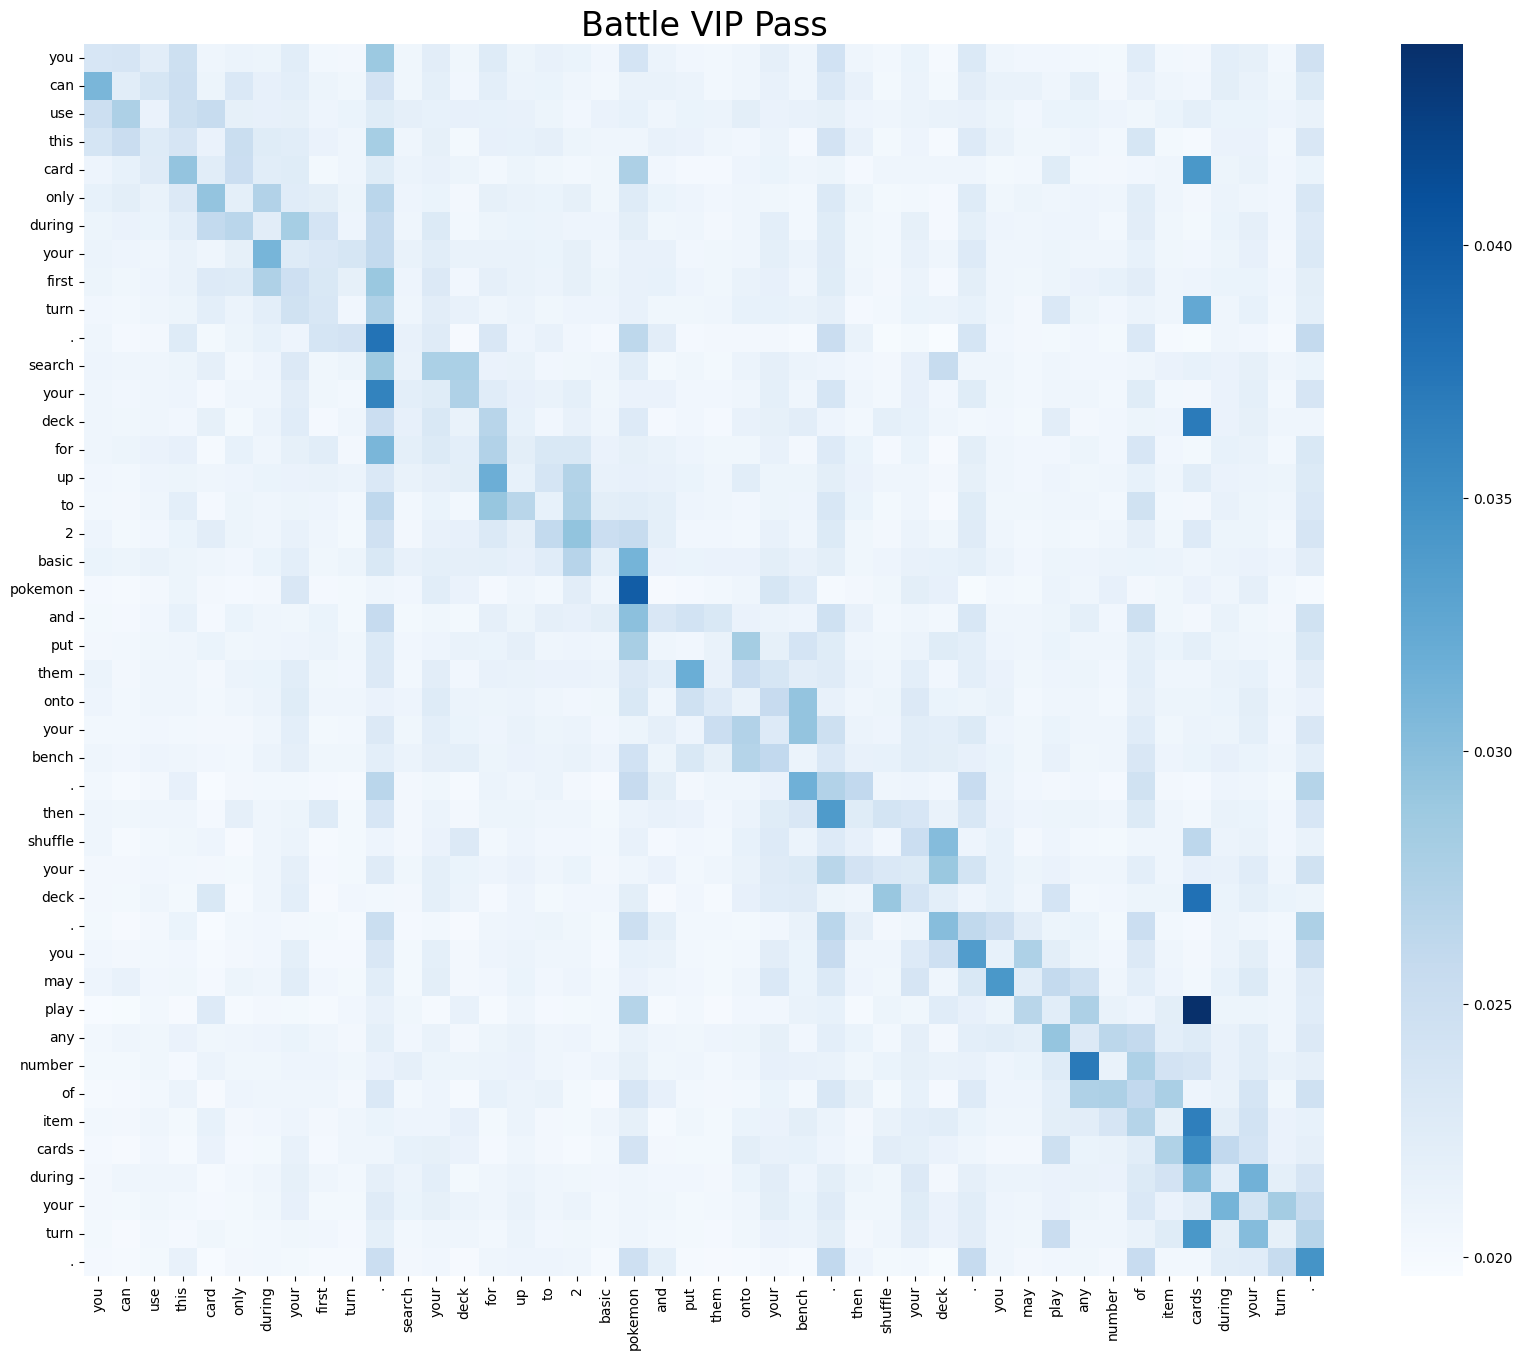

In [36]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[1]),
    pairwise_attentions[1]
)

plt.title(sorted_test_dat_x['name'].iloc[1], fontsize=24);

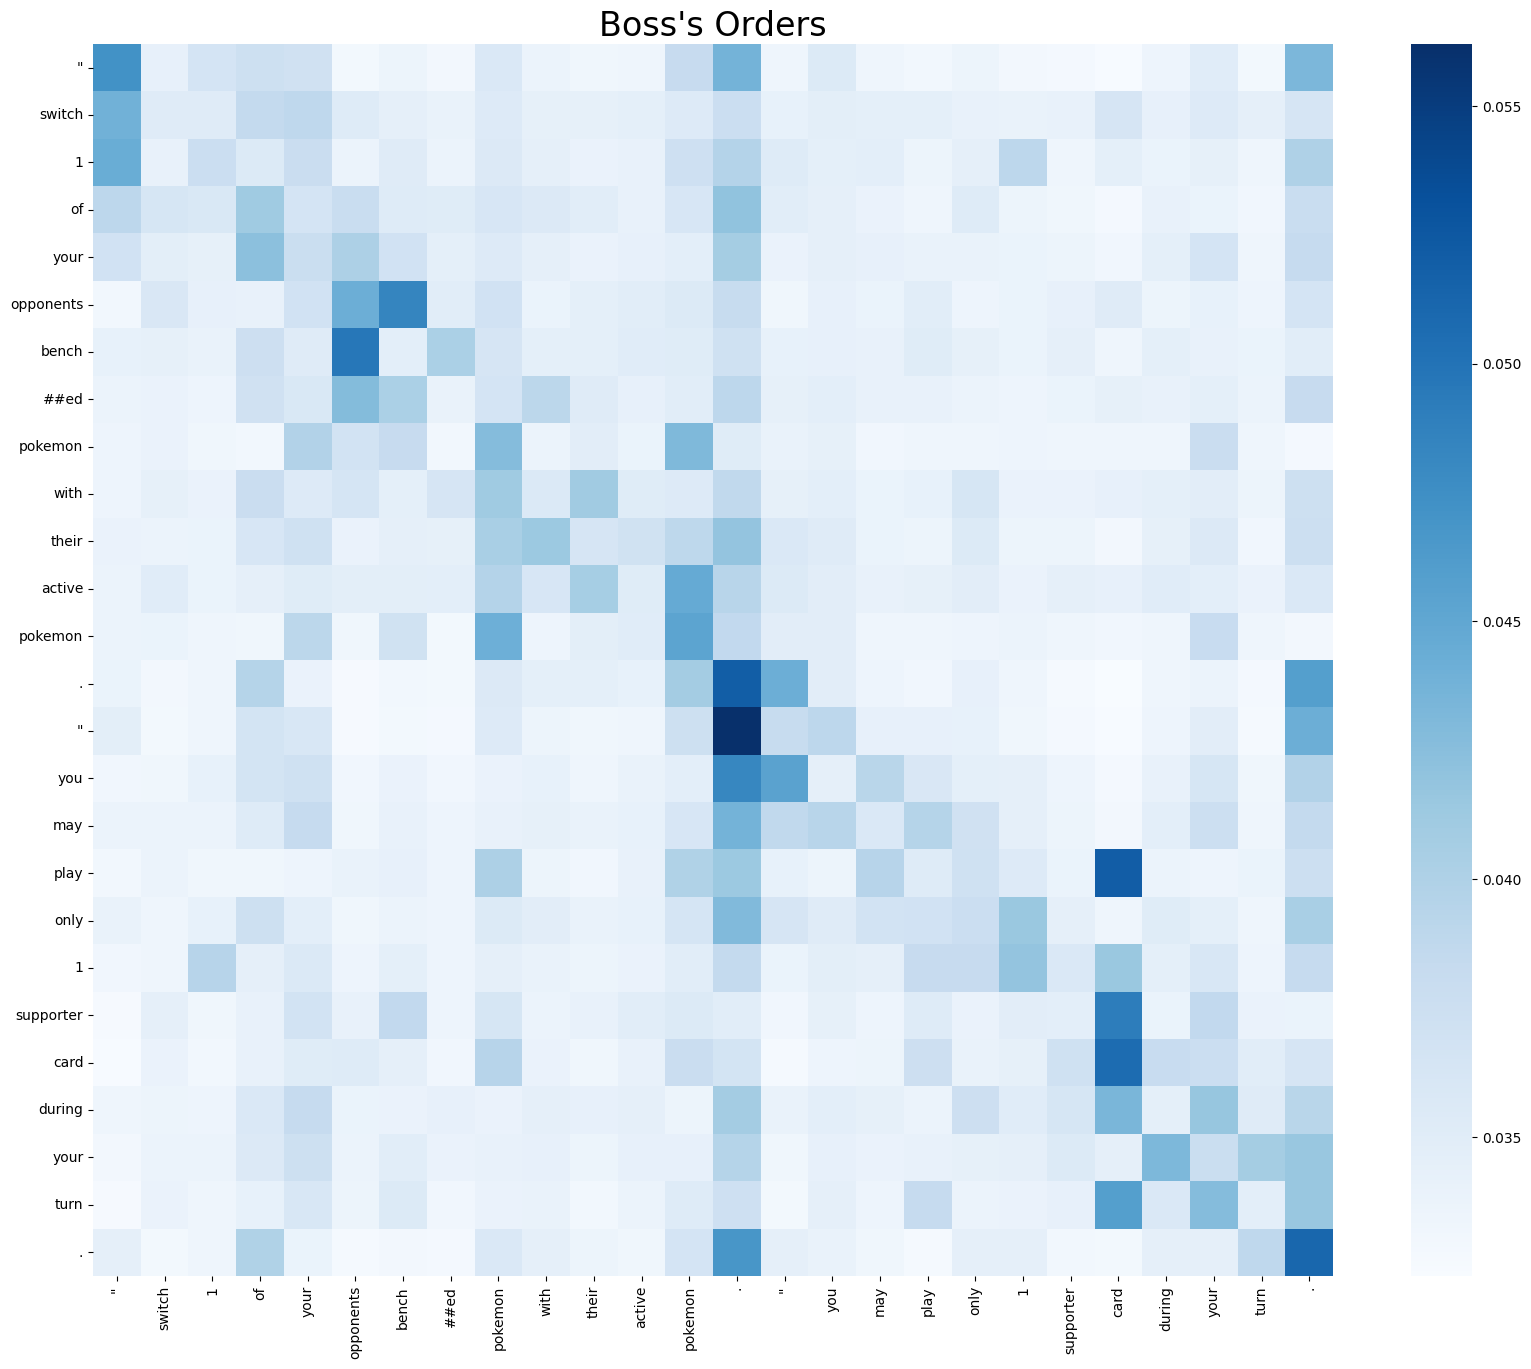

In [54]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[3]),
    pairwise_attentions[3]
)

plt.title(sorted_test_dat_x['name'].iloc[3], fontsize=24);

In [64]:
def attention_barplot(tokens, attn_scores, title):
  plt.figure(figsize=(8, 8))
  sns.barplot(y=tokens, x=attn_scores, errorbar=None)
  plt.xticks(rotation=0)
  plt.title(title)

In [65]:
mean_attentions = attentions.mean(axis=(0, 2, 3))  # Shape [batch_size, num_tokens]
mean_attentions.shape

(10, 256)

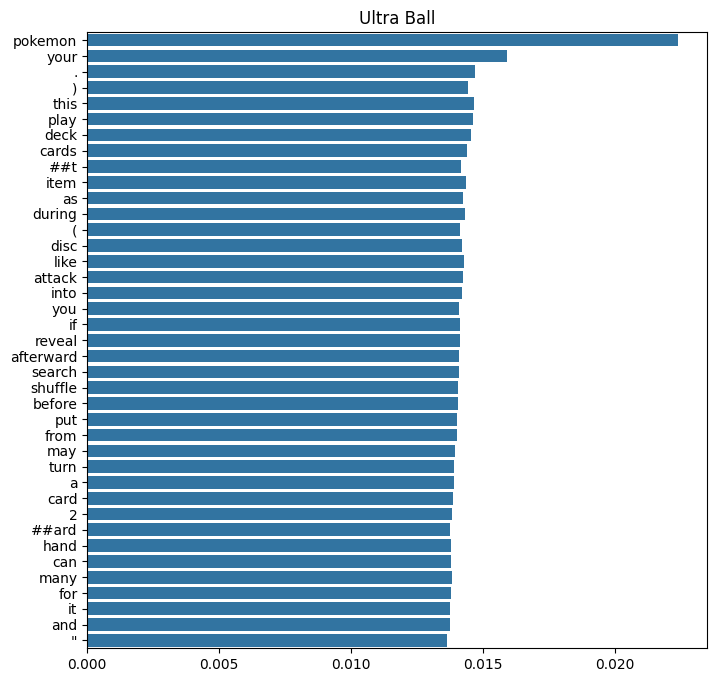

In [66]:
i = 0
mask = ~pd.Series(tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[i])).isin(['[CLS]', '[PAD]', '[SEP]']).to_numpy()
tkns = np.array(tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[i][mask]))
atns = mean_attentions[i][mask]
name = sorted_test_dat_x.iloc[i]['name']
idx = np.argsort(atns)[::-1]

attention_barplot(
    tkns[idx],
    atns[idx],
    name
)

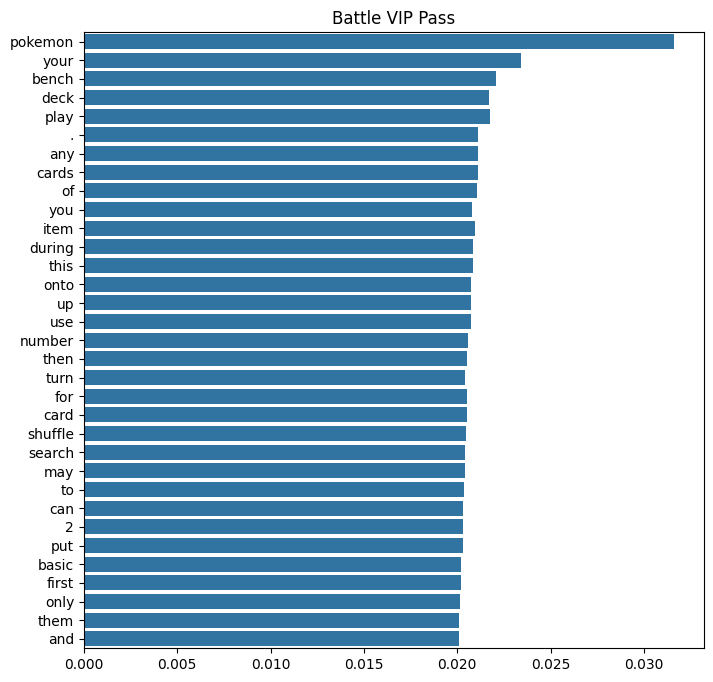

In [67]:
i = 1
mask = ~pd.Series(tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[i])).isin(['[CLS]', '[PAD]', '[SEP]']).to_numpy()
tkns = np.array(tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[i][mask]))
atns = mean_attentions[i][mask]
name = sorted_test_dat_x.iloc[i]['name']
idx = np.argsort(atns)[::-1]

attention_barplot(
    tkns[idx],
    atns[idx],
    name
)

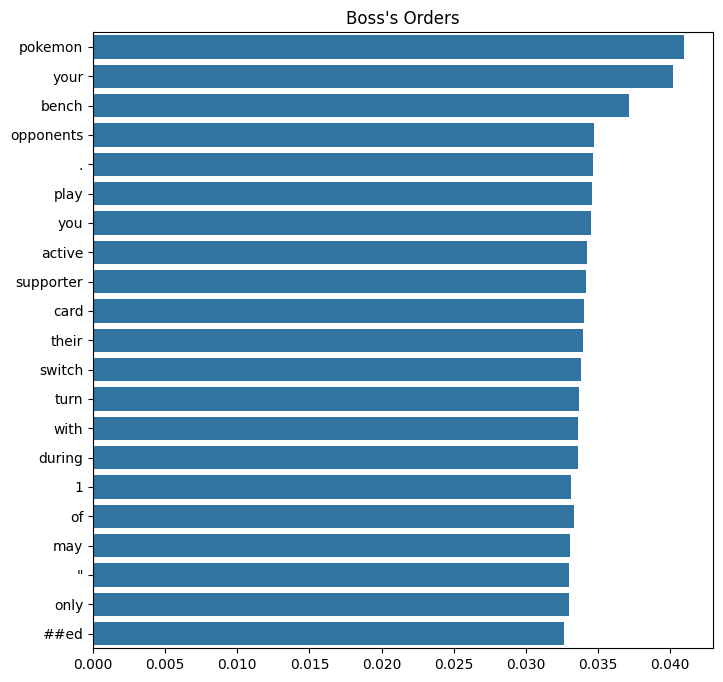

In [68]:
i = 3
mask = ~pd.Series(tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[i])).isin(['[CLS]', '[PAD]', '[SEP]']).to_numpy()
tkns = np.array(tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[i][mask]))
atns = mean_attentions[i][mask]
name = sorted_test_dat_x.iloc[i]['name']
idx = np.argsort(atns)[::-1]

attention_barplot(
    tkns[idx],
    atns[idx],
    name
)